In [18]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from train_utils import *
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix

import uproot
from root_pandas import read_root


import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

You are running on  wudangshan


In [19]:
# Load the data
useRootInput=True

data_tth_orig=None
if useRootInput: # the default
    # Use uproot
    idir = '{}'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')

    file_tth = "{}/tree_2lss1tau.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)


In [20]:
data_tth_orig.describe()

,Lep1_pt,Lep2_pt,Lep1_eta,Lep2_eta,Lep1_phi,Lep2_phi,nSelJets,event,met,met_phi,Higgs_y,Higgs_pt,weight_SM,weight_CP_odd,weight_CP_mixed,HTT_score,mT_lep2,mT_lep1,Hj_tagger_hadTop,mindr_lep2_jet,mindr_lep1_jet,avg_dr_jet,dPhiLL_BBframe_2lss,dEtaLL_BBframe_2lss,dPhiBB_LLframe_2lss,dEtaBB_LLframe_2lss,dEtaBB_2lss,dEtaL1L2_BBframe_3l,dEtaL1L3_BBframe_3l,dEtaBB_L1L2frame_3l,dEtaBB_L1L3frame_3l,mTTH_2lss,mTTH_3l,mTTH_2lss1tau,theta_higgs_ttbar_TTHsystem_2lss1tau,thetaTopTop_ttbarframe_2lss1tau,Tau_pt,Tau_eta,Tau_phi
count,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,4.358400e+04,43584.000000,43584.000000,43584.000000,43584.000000,43584.0,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000
mean,80.776611,37.814930,0.002453,0.002778,0.009698,-0.012621,3.858962,1.104320e+07,95.950638,0.079891,0.000131,144.467545,1.0,0.218034,0.601809,-11.910829,64.760757,97.233597,-29.719421,1.258630,1.277840,2.133345,0.005305,0.718470,0.012246,0.778693,1.030361,0.038744,0.038063,0.021208,0.018829,704.115540,16.791822,626.536743,2.852836,1.595816,52.566780,-0.001968,-0.008276
std,50.277542,21.778221,1.009635,1.042978,1.817238,1.817694,1.315551,8.494279e+06,63.805481,1.777812,0.902978,99.309311,0.0,0.692335,0.422128,33.076504,46.144989,74.709724,45.600082,0.579552,0.593234,0.553459,1.499783,0.639074,1.458863,0.704916,0.794249,0.299683,0.290818,0.175773,0.161523,342.322021,113.695068,301.597656,0.568078,0.773292,38.913521,0.989887,1.809748
min,25.002064,15.000173,-2.493652,-2.496582,-3.141113,-3.141113,1.000000,2.950000e+02,0.327500,-3.141602,-3.025879,1.054993,1.0,0.000007,0.003747,-99.000000,0.000000,0.000000,-99.000000,0.003272,0.011331,0.000000,-3.141548,0.000000,-3.141362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.429489,0.000000,97.485649,0.031558,0.013652,20.001446,-2.298828,-3.141113
25%,46.735332,23.226981,-0.725006,-0.752838,-1.564453,-1.585205,3.000000,4.166240e+06,51.632649,-1.412231,-0.647003,74.699219,1.0,0.027545,0.461868,0.185636,29.753933,44.836788,-99.000000,0.805450,0.809278,1.895476,-0.987286,0.237979,-0.913832,0.252838,0.414257,0.000000,0.000000,0.000000,0.000000,474.850861,0.000000,427.345772,2.802256,0.942415,28.262776,-0.721344,-1.576050
50%,67.278522,31.824586,0.002304,0.005653,0.010266,-0.030504,4.000000,8.431546e+06,83.017204,0.146774,0.004739,122.289062,1.0,0.069321,0.528137,0.676585,58.479061,83.571877,0.075781,1.156008,1.170209,2.162134,0.000000,0.545848,0.000000,0.583498,0.858749,0.000000,0.000000,0.000000,0.000000,623.555298,0.000000,555.843872,3.141593,1.583337,40.058958,0.003815,-0.012947
75%,98.878178,45.413179,0.726196,0.760193,1.595947,1.562378,5.000000,1.762415e+07,124.330141,1.575500,0.645630,188.179688,1.0,0.178740,0.628387,0.927157,89.777163,130.202869,0.358034,1.603571,1.631758,2.431624,1.020156,1.020835,0.955711,1.102107,1.483887,0.000000,0.000000,0.000000,0.000000,841.510635,0.000000,743.594391,3.141593,2.249774,62.217653,0.718384,1.561523
max,699.348083,359.891205,2.497070,2.494141,3.141602,3.141113,12.000000,2.999971e+07,884.521484,3.141113,2.868164,947.718750,1.0,53.146484,20.601562,0.999173,495.900360,870.763733,0.897095,4.483180,4.843023,5.540320,3.141559,5.981307,3.141066,6.707890,4.767090,5.876713,6.449467,4.344077,4.345463,4299.568359,2204.222168,4147.984375,3.141593,3.135246,642.759155,2.299805,3.141602


In [21]:
# De-jag it

data_tth=data_tth_orig # save the original

test=data_tth['SelJet_pt']
l = [len(i) for i in test]
maxl = max(l)

for lab in ['pt', 'eta', 'phi', 'mass', 'isBtag', 'isFromHadTop', 'btagDeepFlavB']:
    label='SelJet_%s'%lab
    tempLab=data_tth[label]
    data_tth.drop([label], axis=1, inplace=True)
    out = pd.DataFrame(tempLab.tolist(),columns=[ 'SelJet%s_%s'%(i, lab) for i in range(maxl)])
    data_tth = pd.concat([data_tth, out], axis=1)


In [22]:
# Remove ill-defined mass columns

for lab in data_tth.columns:
    if 'mass' in lab:
        data_tth.drop([lab], axis=1, inplace=True)

In [23]:
print(data_tth_orig.columns)

print(maxl)

print(data_tth.columns)

Index(['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
       'nSelJets', 'SelJet_eta', 'SelJet_phi', 'SelJet_mass', 'SelJet_isBtag',
       'SelJet_isFromHadTop', 'SelJet_btagDeepFlavB', 'event', 'met',
       'met_phi', 'Higgs_y', 'Higgs_pt', 'weight_SM', 'weight_CP_odd',
       'weight_CP_mixed', 'HTT_score', 'mT_lep2', 'mT_lep1',
       'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
       'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
       'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'dEtaL1L2_BBframe_3l',
       'dEtaL1L3_BBframe_3l', 'dEtaBB_L1L2frame_3l', 'dEtaBB_L1L3frame_3l',
       'mTTH_2lss', 'mTTH_3l', 'mTTH_2lss1tau',
       'theta_higgs_ttbar_TTHsystem_2lss1tau',
       'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi'],
      dtype='object')
12
Index(['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
       'nSelJets', 'event', 'met', 'met_phi',
       ...
       'SelJet2_

In [24]:
#thevars=['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
#               'met', 'met_phi', 'Tau_pt', 'Tau_eta', 'Tau_phi', 'HTT_score']
#for i in range(12):
#    thevars.append('SelJet%s_pt'%i)
#    thevars.append('SelJet%s_eta'%i)
#    thevars.append('SelJet%s_phi'%i)
#    thevars.append('SelJet%s_mass'%i)
#    thevars.append('SelJet%s_isBtag'%i)
#    thevars.append('SelJet%s_isFromHadTop'%i)

thevars=[
        'Lep1_pt', 
        'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
         'nSelJets',
         'met', 'met_phi', 
         'HTT_score', 
         'Hj_tagger_hadTop',
         'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
         'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
         'dEtaBB_LLframe_2lss',
         'dEtaBB_2lss',
         'mTTH_2lss1tau',
         'theta_higgs_ttbar_TTHsystem_2lss1tau',
         'thetaTopTop_ttbarframe_2lss1tau', 
         'Tau_pt', 'Tau_eta', 'Tau_phi'
    ]
#for i in range(12):
#    thevars.append('SelJet%s_pt'%i)
#    thevars.append('SelJet%s_eta'%i)
#    thevars.append('SelJet%s_phi'%i)
##    thevars.append('SelJet%s_mass'%i)
#    thevars.append('SelJet%s_isBtag'%i)
#    thevars.append('SelJet%s_isFromHadTop'%i)
#    thevars.append('SelJet%s_btagDeepFlavB'%i)
    
spect=['event', 'Higgs_y', 'Higgs_pt', 'weight_SM', 'weight_CP_odd']


print('Training features:', thevars)
print('Spectator features:', spect)

Training features: ['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi']
Spectator features: ['event', 'Higgs_y', 'Higgs_pt', 'weight_SM', 'weight_CP_odd']


In [25]:
print(thevars)
bkg = data_tth[thevars]
sig = data_tth[thevars]

bkg.fillna(0, inplace=True)
sig.fillna(0, inplace=True)


wgtbkg=pd.DataFrame(data_tth['weight_SM'].tolist(), columns=['weight'])
wgtsig=pd.DataFrame(data_tth['weight_CP_odd'].tolist(), columns=['weight'])


#bkg['weight']=data_tth.iloc[:,data_tth.columns.get_loc('weight_SM')]
#sig['weight']=data_tth.iloc[:,data_tth.columns.get_loc('weight_CP_odd')]

labbkg = pd.DataFrame(np.zeros_like(bkg['Lep1_pt']).tolist(), columns=['label'])
labsig = pd.DataFrame(np.ones_like(bkg['Lep1_pt']).tolist(), columns=['label'])


bkg = pd.concat([bkg, wgtbkg, labbkg], axis=1)
sig = pd.concat([sig, wgtsig, labsig], axis=1)

bkg.head()
#sig = sig[sig['weight']<20]
sig['weight'] = sig['weight'].apply(lambda x: x if x <10. else 10.)
#print(bkg.columns)

labelled_set=pd.concat([sig, bkg], axis=0)

labelled_set=shuffle(labelled_set)


labs=thevars
labs.append('weight')
X=labelled_set[labs]
y=labelled_set['label']
weight=labelled_set['weight']

pd.set_option('display.max_columns', None)
#labelled_set.head()

['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi']


/home/junzi/.local/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [26]:

print(bkg.head())

print(sig.head())


      Lep1_pt    Lep2_pt  Lep1_eta  Lep2_eta  Lep1_phi  Lep2_phi  nSelJets  \
0   65.060692  28.938643  1.078369  1.967041 -2.828613  0.322815         3   
1  116.764389  70.972816 -1.463379 -1.106201  0.728760  0.578613         5   
2   81.278633  18.616665  2.194824  1.765625  0.528198 -1.604736         3   
3  125.633125  60.191414  0.605103  0.173615 -1.022949 -3.012695         5   
4   51.864380  38.232483  1.734131  0.914551 -0.113174 -2.233887         5   

          met   met_phi  HTT_score  Hj_tagger_hadTop  mindr_lep2_jet  \
0  172.891312 -2.951660   0.024360        -99.000000        0.691453   
1   46.341152 -0.300293   0.976259          0.253784        1.549022   
2  167.847046 -1.923584   0.070585        -99.000000        0.990875   
3   87.626472  2.803223   0.895850          0.437349        0.741387   
4   69.026421 -2.179688   0.947869          0.721005        0.486511   

   mindr_lep1_jet  avg_dr_jet  dPhiLL_BBframe_2lss  dEtaLL_BBframe_2lss  \
0        1.177768    1.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1534534, shuffle=True)

X_train_wgt=X_train['weight']
X_train=X_train.drop(['weight'], axis=1, inplace=False)
X_test_wgt=X_test['weight']
X_test=X_test.drop(['weight'], axis=1, inplace=False)

train_dmatrix = xgb.DMatrix(data=X_train,label=y_train,weight=X_train_wgt)
test_dmatrix = xgb.DMatrix(data=X_test,label=y_test,weight=X_test_wgt)

#perm = np.random.permutation(len(X_train))
#X_train = X_train[perm]
#y_train = y_train[perm]
#X_train_wgt = X_train_wgt[perm]

#perm = np.random.permutation(len(X_train))
#X_test = X_test[perm]
#y_test = y_test[perm]
#X_test_wgt = X_test_wgt[perm]


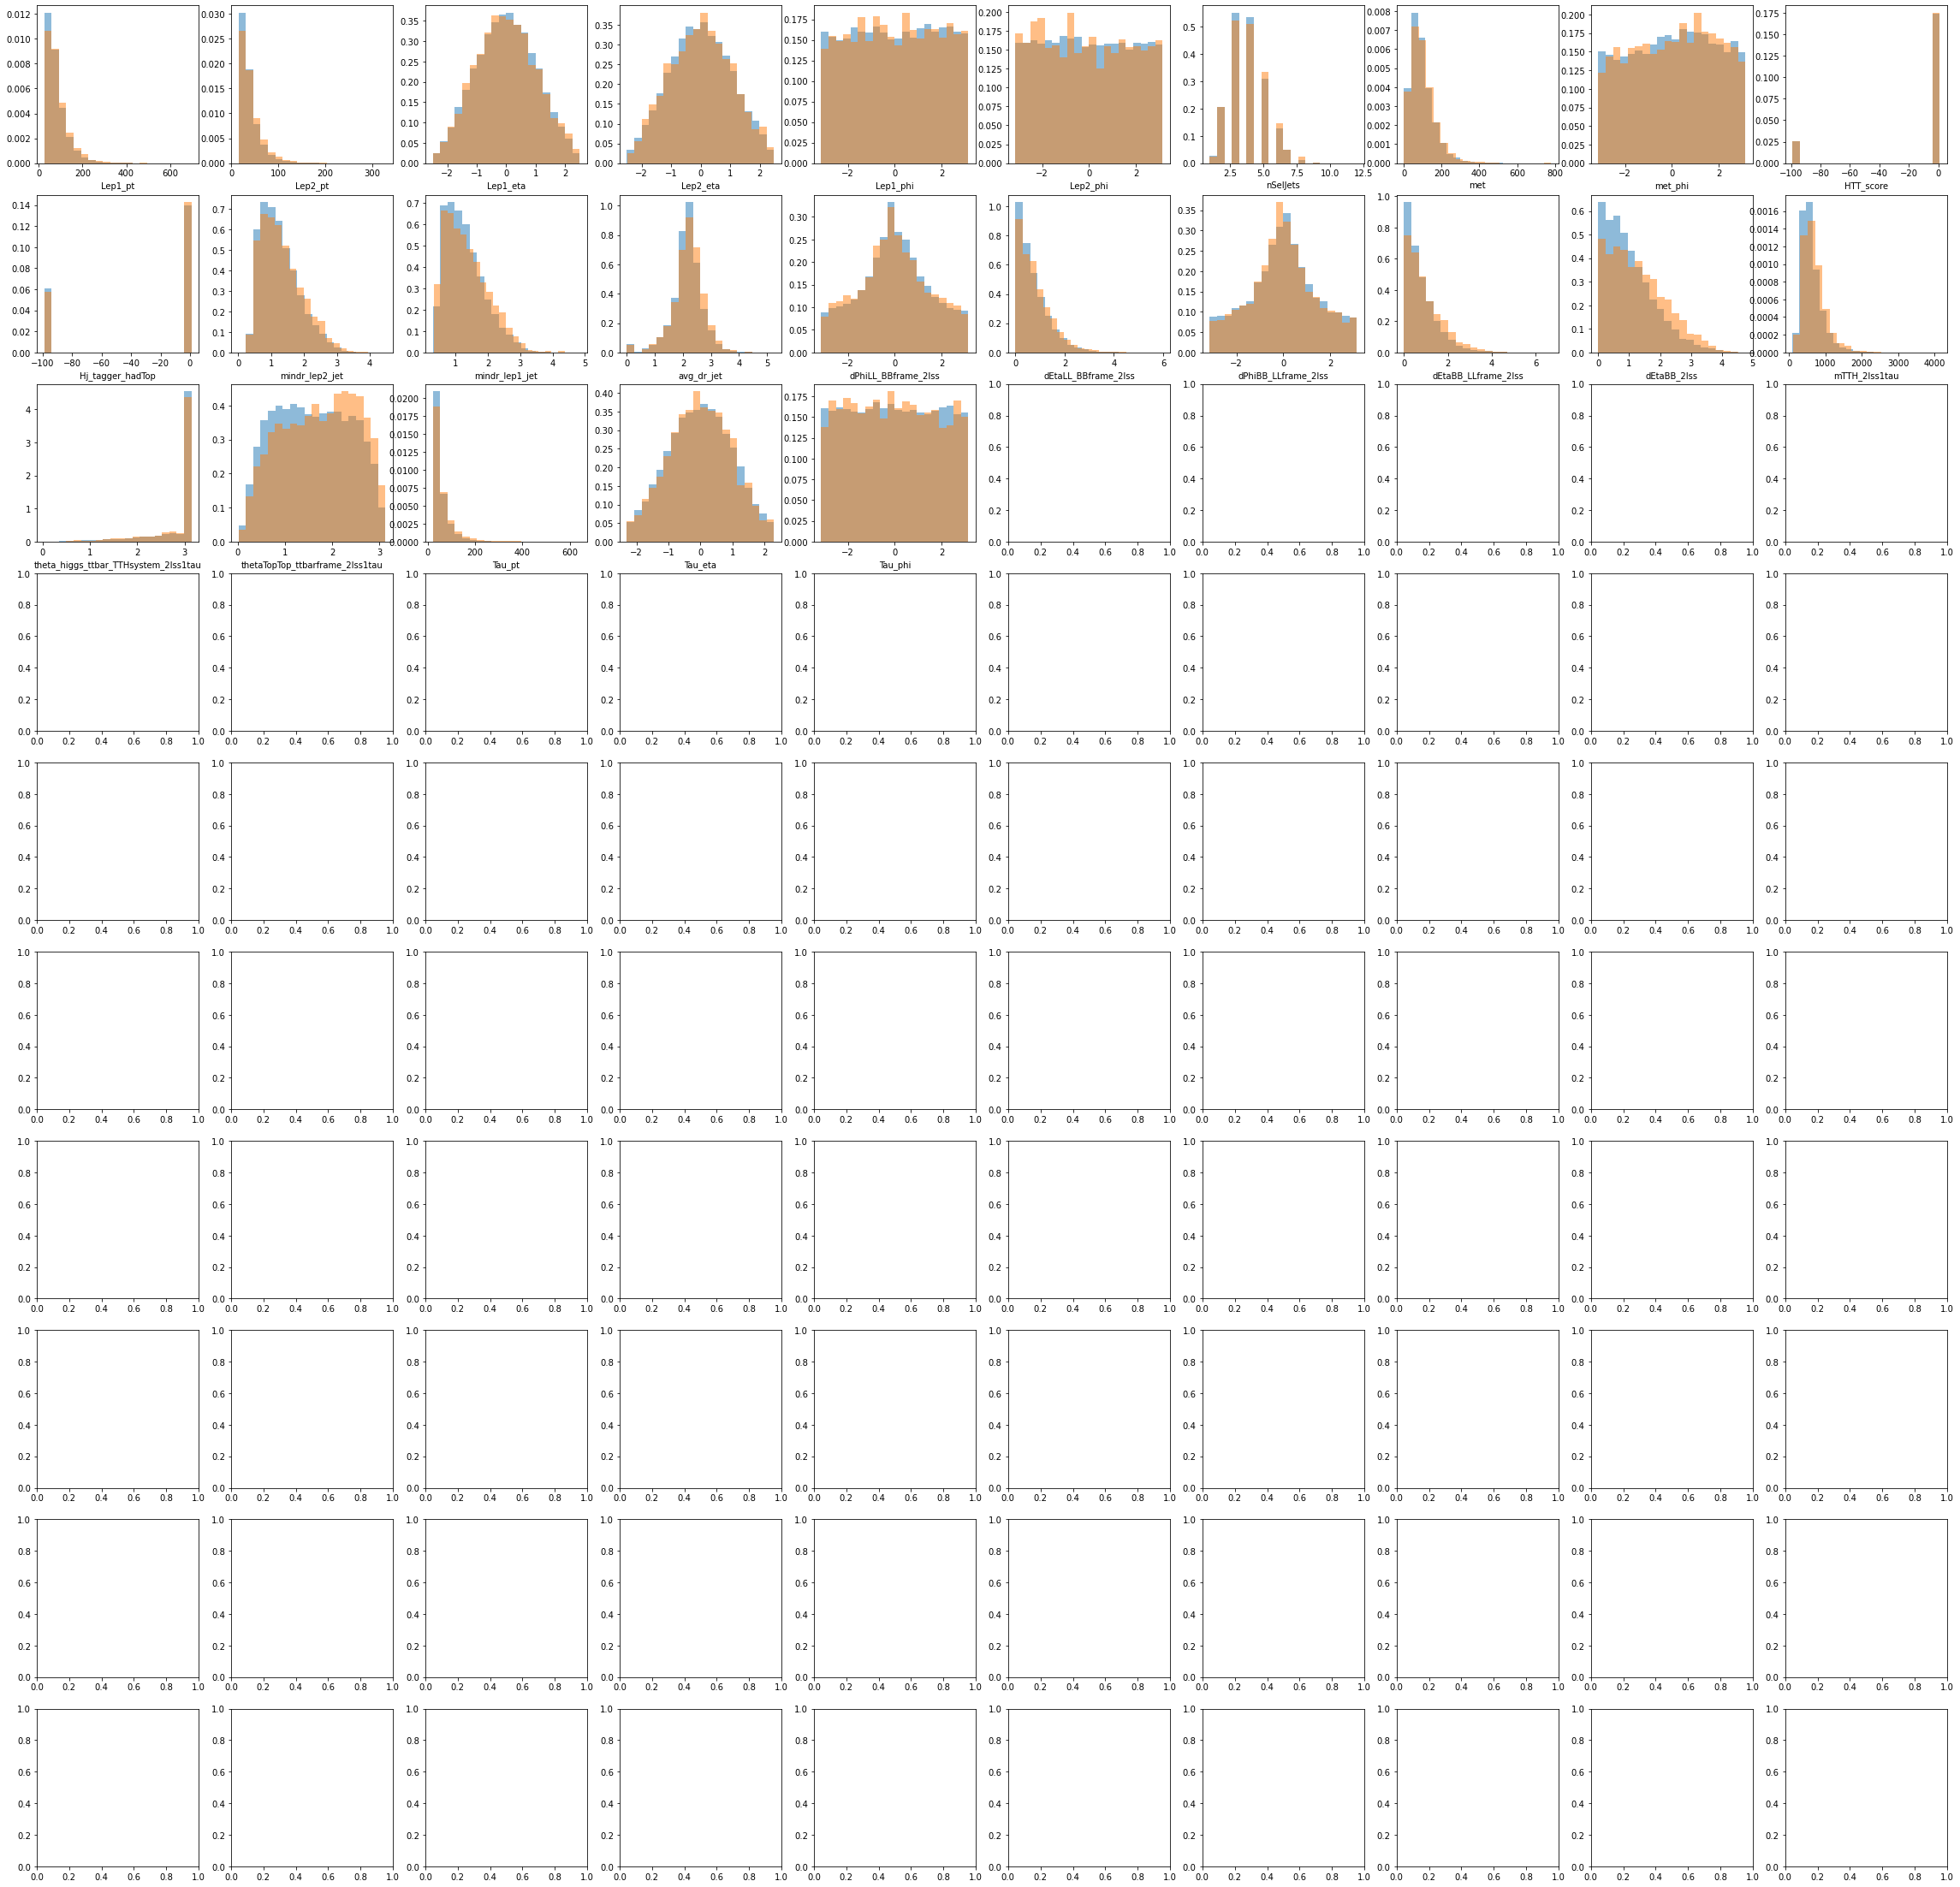

In [28]:
fix, axs= plt.subplots(10,10, figsize=(40,40))
axs = axs.ravel()

for i,ax in enumerate(axs):
    if i >= len(thevars):
        continue
    var=thevars[i]
    if var=='weight':
        continue
    ax=axs[i]
    #ax.hist(X_train[var], label='%s'%var)
    ax.hist(X_train[var][y_train[:]==0 ], weights=X_train_wgt[y_train[:]==0 ], density=True, alpha=0.5, bins=20)
    ax.hist(X_train[var][y_train[:]==1 ], weights=X_train_wgt[y_train[:]==1 ], density=True, alpha=0.5, bins=20)
    #ax.set_yscale('log')
    ax.set_xlabel(var)



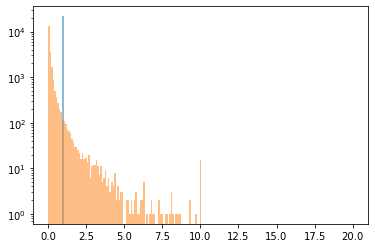

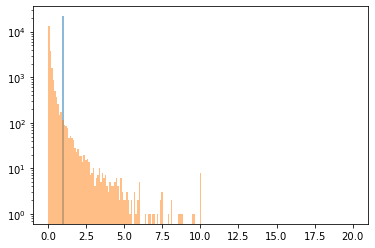

In [29]:
plt.hist(X_train_wgt[y_train[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.yscale("log")
plt.hist(X_train_wgt[y_train[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.show()
#plt.hist(X)
plt.hist(X_test_wgt[y_test[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.yscale("log")
plt.hist(X_test_wgt[y_test[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.show()

In [30]:
pd.set_option('display.max_columns', None)
X_train.head()

#import seaborn as sns
#sns.pairplot(labelled_set, hue='label')  
print(X_train.columns)
print(X_train_wgt[y_train[:]==0])

score_test=None

Index(['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
       'nSelJets', 'met', 'met_phi', 'HTT_score', 'Hj_tagger_hadTop',
       'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss',
       'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss', 'dEtaBB_LLframe_2lss',
       'dEtaBB_2lss', 'mTTH_2lss1tau', 'theta_higgs_ttbar_TTHsystem_2lss1tau',
       'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi'],
      dtype='object')
3430     1.0
19037    1.0
41422    1.0
27802    1.0
34117    1.0
        ... 
32256    1.0
12167    1.0
20996    1.0
40815    1.0
39769    1.0
Name: weight, Length: 21767, dtype: float64


In [67]:
#radb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_depth=3, random_state=7)
#gradb.fit(X_train, y_train, sample_weight=X_train_wgt)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=20, random_state=7)

In [31]:
#preds_train = gradb.predict(X_train)
#preds_test =  gradb.predict(X_test)
#score_train = gradb.predict_proba(X_train)[:,1]
#score_test = gradb.predict_proba(X_test)[:,1]


#plot_roc(y_train, score_train, 'training')
#plot_roc(y_test, score_test, 'test')


#print("Confusion Matrix:")
#print('train', confusion_matrix(y_train, preds_train))

#print("Confusion Matrix:")
#print('test', confusion_matrix(y_test, preds_test))

In [32]:
print(type(X_train_wgt))

<class 'pandas.core.series.Series'>


In [45]:
#
#xg_class = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='aucpr', colsample_bytree = 0.1, learning_rate = 0.1,
#                max_depth = 5, n_estimators = 1000, verbosity=0)

#xg_class = xgb.XGBClassifier(objective ='binary:logistic', alpha=10, n_estimators=1000, max_depth=4, learning_rate=0.1, verbosity=0)

#xg_class = xgb.XGBClassifier(objective ='binary:logistic', alpha=2, n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=0)
# WORKING: xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=1)
xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=1, gamma=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
#early_stopping_rounds=10
xg_class.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])


[0]	validation_0-error:0.18132	validation_0-logloss:0.65362	validation_1-error:0.17081	validation_1-logloss:0.65240
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.18132	validation_0-logloss:0.62146	validation_1-error:0.17081	validation_1-logloss:0.61924
[2]	validation_0-error:0.18132	validation_0-logloss:0.59481	validation_1-error:0.17081	validation_1-logloss:0.59174
[3]	validation_0-error:0.18132	validation_0-logloss:0.57311	validation_1-error:0.17081	validation_1-logloss:0.56929
[4]	validation_0-error:0.18132	validation_0-logloss:0.55488	validation_1-error:0.17081	validation_1-logloss:0.55046
[5]	validation_0-error:0.18132	validation_0-logloss:0.53941	validation_1-error:0.17081	validation_1-logloss:0.53446
[6]	validation_0-error:0.18132	validation_0-logloss:0.52667	validation_1-error:0.17081	validation_1-logloss:0.52125
[7]	validation_0-error:

[69]	validation_0-error:0.18033	validation_0-logloss:0.43839	validation_1-error:0.17085	validation_1-logloss:0.44359
[70]	validation_0-error:0.18012	validation_0-logloss:0.43815	validation_1-error:0.17089	validation_1-logloss:0.44367
[71]	validation_0-error:0.18012	validation_0-logloss:0.43792	validation_1-error:0.17089	validation_1-logloss:0.44371
Stopping. Best iteration:
[61]	validation_0-error:0.18084	validation_0-logloss:0.44028	validation_1-error:0.17078	validation_1-logloss:0.44335



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
#eval_set = [train_dmatrix, test_dmatrix ]
#
#params = {
#    'max_depth': 6,
#    'objective': 'binary:logistic',
#    'eval_metric': ['error', 'logloss'],
#    'eval_set': eval_set
#}

#xg_class = xgb.train(params, train_dmatrix)


In [47]:
#pred = xg_class.predict(test_dmatrix)
#pred=np.asarray([np.argmax(line) for line in pred])

#cm = confusion_matrix(y_test, pred)
#import seaborn as sns
#def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
#    plt.figure(figsize=[7, 6])
#    norm_cm = cm
#    if normalized:
#        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

#plot_confusion_matrix(cm, ['CP odd', 'CP even'])

FPR range: 0.0 1.0
TPR range: 0.0 1.0


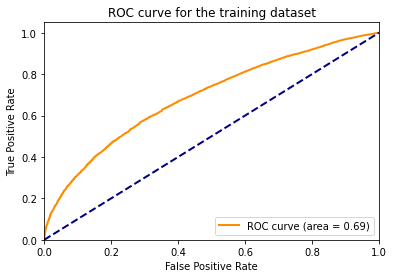

FPR range: 0.0 1.0
TPR range: 0.0 1.0


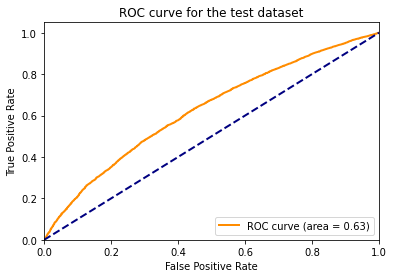

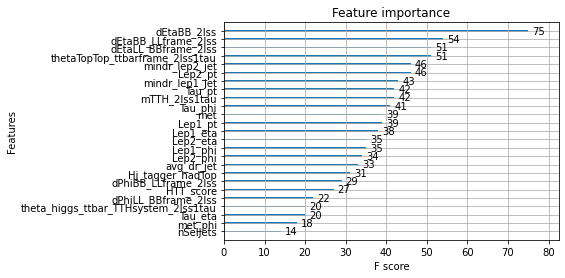

<Figure size 1152x864 with 0 Axes>

Accuracy (train): 81.92%
Accuracy (test): 82.92%


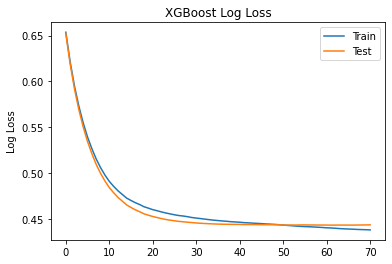

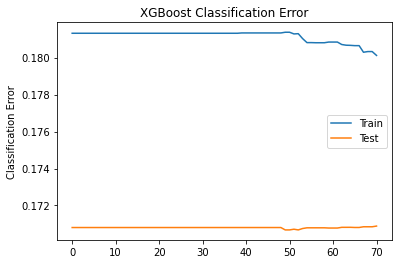

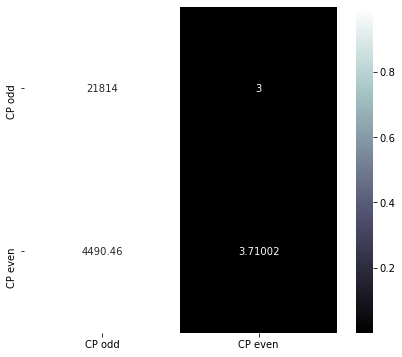

In [48]:

preds_train = xg_class.predict_proba(X_train)[:,0]
preds_test = xg_class.predict_proba(X_test)[:,0]

#preds_train=np.argmax(xg_class.predict_proba(X_train), axis=1)
#preds_test =np.argmax(xg_class.predict_proba(X_test), axis=1)

preds_cat_train = xg_class.predict(X_train)
preds_cat_test  = xg_class.predict(X_test)
# ROC curves
sample_weight=X_train_wgt
plot_roc(y_train, preds_train, sample_weight=X_train_wgt, label='training', debug=True)
plot_roc(y_test, preds_test, sample_weight=X_test_wgt, label='test', debug=True)



xgb.plot_importance(xg_class)
plt.figure(figsize = (16, 12))
plt.show()
accuracy_train = accuracy_score(y_train, preds_cat_train,sample_weight=X_train_wgt)
print("Accuracy (train): %.2f%%" % (accuracy_train * 100.0))
accuracy_test = accuracy_score(y_test, preds_cat_test, sample_weight=X_test_wgt)
print("Accuracy (test): %.2f%%" % (accuracy_test * 100.0))


results = xg_class.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


#pred=np.asarray([np.argmax(line) for line in pred])
#Confusion matrix whose i-th row and j-th column entry indicates
# the number of samples with true label being i-th class and prediced label being j-th class.
import seaborn as sns
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

cm = confusion_matrix(y_test, preds_cat_test, sample_weight=X_test_wgt)
plot_confusion_matrix(cm, ['CP odd', 'CP even'])

In [ ]:
convert_model(model,input_variables=input_vars,output_xml=os.path.join(save_dir,'xgboost-{}.xml'.format(channel)))

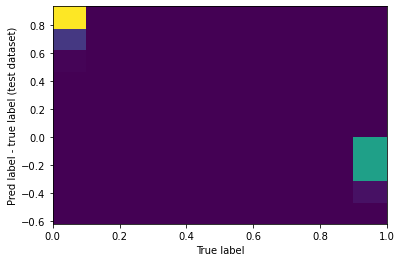

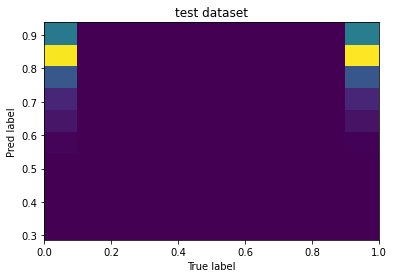

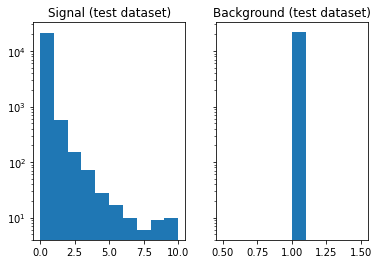

In [24]:
from train_utils import *
plot_rel_pred(y_test, preds_test, 'test')
plot_pred(y_test, preds_test, 'test')

if score_test:
    plot_score(y_test, score_test, 'test')

plot_weights(X_test_wgt, y_test, 'test')

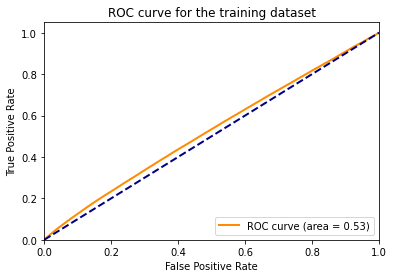

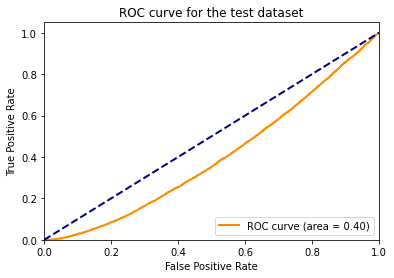

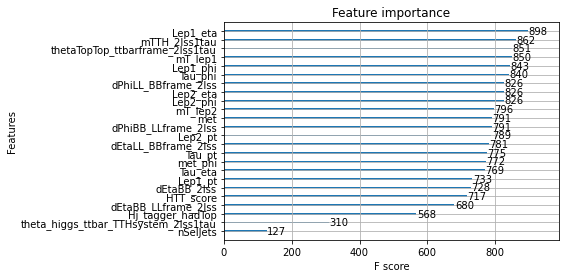

<Figure size 1152x864 with 0 Axes>

In [113]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                   num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)#

cv_results.head()

print((cv_results["test-rmse-mean"]).tail(1))

[18:34:05] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[18:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:05] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[18:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:05] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[18:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:34:06] INFO: .

[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned node

[18:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[18:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[18:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:34:18] ======== Monitor: Learner ========
[18:34:18] Configure: 0.000534s, 1 calls @ 534us

[18:34:18] EvalOneIter: 0.582356s, 50 calls @ 582356us

[18:34:18] GetGradient: 0.152019s, 50 calls @ 152019us

[18:34:18] PredictRaw: 0.000176s, 50 calls @ 176us

[18:34:18] UpdateOneIter: 2.7887s, 50 calls @ 2788703us

[18:34:18] ======== Monitor: GBTree ========
[18:34:18] BoostNewTrees: 2.63511s, 50 calls @ 2635107us

[18:34:18] CommitModel: 6.3e-05s, 50 calls @ 63us

[18:34:18] ======== Monitor: TreePruner ========
[18:34:18] PrunerUpdate: 0.014012s, 50 calls @ 14012us

[18:34:18] ======== Monitor: Learner ========
[18:34:18] Configure: 0.018768s, 1 call

In [111]:

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# CV model
model = xgb.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, weight=X_train_wgt,  cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


TypeError: cross_val_score() got an unexpected keyword argument 'weight'

In [107]:

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print("MSE: %f" % mean_squared_error(y_test,preds))



xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


#X = data[thevars]
#y =
#X, y = data.iloc[:,:-1],data.iloc[:,-1]


#xgmat <- xgb.DMatrix(data, label = label, weight = weight, missing = -999.0)

NameError: name 'preds' is not defined

In [ ]:
xgmat= xgb.DMatrix(data_dmatrix, label = y, weight = weight, missing = -999.0)
params = {"objective":"binary:logitraw",
          'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10,
            #"bst:eta": 0.1,
            #"bst:max_depth": 6,
            "eval_metric" : "auc",
            "nthread": 4}
          
watchlist = { "train" :xgmat}
nrounds = 120
print ("loading data end, start to boost trees")
bst = xgb.train(param, xgmat, nrounds, watchlist );
# save out model
xgb.save(bst, "higgCP.model")
print ('finish training')